# Analysis of indel calls in MiSeq runs
### Cedric Chauve, January 28, 2021.

This notebook provides a high-level analysis of the indels calls from https://github.com/contextual-genomics/indels-pipeline on a set of 248 MiSeq runs.

## Experiments and results

The experiment consisted in running the indels pipeline (branch BOVERI-448, January 26 2020) on the set of MiSeq runs listed in the file   
```data/runs_indel_testing_18012021_MiSeq.csv```  
The samples in these runs are listed in the log file  
```log/runs_indel_testing_18012021_MiSeq_input.log```.  

The runs were processed in three stages, as some run failed for unexplained reasons. The second and third sets of submitted runs are described in the files 
```data/runs_indel_testing_18012021_MiSeq_failed.csv```  
```data/runs_indel_testing_18012021_MiSeq_failed_failed.csv```  
and the corresponding log files are
```log/runs_indel_testing_18012021_MiSeq_failed_input.log```
```log/runs_indel_testing_18012021_MiSeq_failed_failed_input.log```.  

The commands used to submit these jobs used the ```run_utils``` script:  
```./bin/run_utils.py data/runs_indel_testing_18012021_MiSeq.csv ch-testdata BOVERI-448```  
```./bin/run_utils.py data/runs_indel_testing_18012021_MiSeq_failed.csv ch-testdata BOVERI-448```  
```./bin/run_utils.py data/runs_indel_testing_18012021_MiSeq_failed_failed.csv ch-testdata BOVERI-448```.  

The results are available in the directory ```results/runs_indel_testing_18012021_MiSeq```. There is one subdirectory per run that contains six files: five files recording all warnings raised during processing the data and an indels calls dump TSV file.  

All dump files for all runs have also been aggregated into several large dump files:
- ```ctrl_samples_indels_dump.tsv```, ```DNA_samples_indels_dump.tsv```, ```misc_samples_indels_dump.tsv``` record all individual indel calls for the samples separated in three groups (control samples, patient samples, other samples);
- ```ctrl_grouped_samples_indels_dump.tsv```, ```DNA_grouped_samples_indels_dump.tsv```, ```misc_grouped_samples_indels_dump.tsv``` record the same calls but grouping together identical calls and listing the samples they occur into, the mean VAF and the VAF standard deviation;
- ```DNA_grouped_samples_with_aliquots_indels_dump.tsv``` is similar to ```DNA_grouped_samples_indels_dump.tsv``` with added information about aliquots, for patient samples.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Auxiliary functions

def plot_histograms(df_dict, col, title, binwidth=0.005):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title)
    plt.subplot(131)
    sns.histplot(df_dict['ctrl'], x=col, kde=False, binwidth=binwidth)
    plt.title(SAMPLE_TYPES_DICT['ctrl'])
    plt.subplot(132)
    sns.histplot(df_dict['DNA'], x=col, kde=False, binwidth=binwidth)
    plt.title(SAMPLE_TYPES_DICT['DNA'])
    plt.subplot(133)
    sns.histplot(df_dict['misc'], x=col, kde=False, binwidth=binwidth)
    plt.title(SAMPLE_TYPES_DICT['misc'])
    plt.show()
    
def plot_scatter(df_dict, colx, coly, title, binwidth=0.005):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title)
    plt.subplot(131)
    sns.scatterplot(data=df_dict['ctrl'], x=colx, y=coly, hue='v_type')
    plt.title(SAMPLE_TYPES_DICT['ctrl'])
    plt.subplot(132)
    sns.scatterplot(data=df_dict['DNA'], x=colx, y=coly, hue='v_type')
    plt.title(SAMPLE_TYPES_DICT['DNA'])
    plt.subplot(133)
    sns.scatterplot(data=df_dict['misc'], x=colx, y=coly, hue='v_type')
    plt.title(SAMPLE_TYPES_DICT['misc'])
    plt.show()
    
# Converter to convert the string representing a list of samples and VAF into an actual list of pairs
PRECISION = 0.001
converter_samples_vaf = lambda x: [(x.split(':')[0], float(x.split(':')[1])) for x in x.split(',')]
converter_vaf = lambda x: round(PRECISION * round(float(x)/PRECISION), 3)
converters = {'samples:vaf': converter_samples_vaf, 'avg_vaf': converter_vaf, 'std_vaf': converter_vaf, 'VAF': converter_vaf}

# Type of a variant
DEL, INS, DELINS, MNV = 'del', 'ins', 'delins', 'mnv'
VARIANT_TYPES = [DEL, INS, DELINS, MNV]
def variant_type(ref_seq, alt_seq):
    ref_len, alt_len = len(ref_seq), len(alt_seq)
    if ref_len == alt_len:
        return MNV, ref_len, alt_len
    elif ref_len == 1 and ref_seq[0] == alt_seq[0]:
        return INS, ref_len, alt_len
    elif alt_len == 1 and ref_seq[0] == alt_seq[0]:
        return DEL, ref_len, alt_len
    else:
        return DELINS, ref_len, alt_len
    
def variant_nb_per_type(df):
    nb = {v_type: 0 for v_type in VARIANT_TYPES}
    for _, row in df.iterrows():
        nb[row['v_type']] += 1
    return nb

def filter_by_amplicons(df, excluded_amplicons):
    index_to_drop = []
    for index, row in df.iterrows():
        source = row['source'].split(',')
        to_exclude = False
        for amplicon in source:
            if amplicon in excluded_amplicons:
                to_exclude = True
        if to_exclude:
            index_to_drop.append(index)
    df.drop(index=index_to_drop, inplace=True)

def print_nb_calls(df, df_grouped, title):
    print(title)
    for sample_type in SAMPLE_TYPES:
        print(f"\t{SAMPLE_TYPES_DICT[sample_type]}\tindividual calls: {len(df[sample_type].index)}\tgrouped calls: {len(df_grouped[sample_type].index)}")
        nb_per_type = ' '.join([f"{v_type}:{count}" for v_type, count in variant_nb_per_type(df[sample_type]).items()])
        nb_per_type_grouped = ' '.join([f"{v_type}:{count}" for v_type, count in variant_nb_per_type(df_grouped[sample_type]).items()])
        print(f"\t\t\tindividual calls: {nb_per_type}\tgrouped calls: {nb_per_type_grouped}")
        
def extract_groups_colocalized_calls(df, spacer_len=5):
    df.sort_values(by=['chr', 'pos'], inplace=True)
    groups = {}
    current_group, group_id = [], 1
    for index, row in df.iterrows():
        current_chr, current_pos = row['chr'], row['pos']
        if current_group == [] or (current_chr == prev_chr and current_pos <= prev_pos + spacer_len):
            current_group.append(index)
        else:
            groups[group_id] = df.loc[current_group, :].sort_values(by=['pos'])
            group_id += 1
            current_group = [index]
        prev_chr, prev_pos = current_chr, current_pos
    groups[group_id] = df.loc[current_group, :].sort_values(by=['pos'])
    return groups

In [3]:
# Loading the data: manifests and list of amplicons to exclude

MANIFEST_FILES = {
    'CG001.v3': '../assets/CG001.v3.4_Amplicon_Manifest_Panel3.4.4_20170921.tsv',
    'CG001.v4': '../assets/CG001v4.0_Amplicon_Manifest_Panel4.0.3_20181101.tsv',
    'CG001.v5': '../assets/CG001v5.1_Amplicon_Manifest_Panel5.1.12_20200911.tsv'
}
MANIFEST_DF = {}
for manifest_id, manifest_file in MANIFEST_FILES.items():
    MANIFEST_DF[manifest_id] = pd.read_csv(manifest_file, sep='\t')
    
FINGERPRINT_GENE_MAP = {
        'FZD3' : 'rs10092491',
        'FBXO27-ACP7' : 'rs576261',
        'UBAC2' : 'rs1058083',
        'RAB31' : 'rs9951171',
        'PALLD' : 'rs6811238',
        'TRIM5' : 'rs1498553',
        'LINC01524-TSHZ2' : 'rs1523537',
        'C15orf53-C15orf54' : 'rs1821380',
        'SYNE1' : 'rs214955',
        'CRP' : 'rs3091244',
        'PTN' : 'rs321198',
        'TRDMT1' : 'rs3780962',
        'CMTM8-CMTM7' : 'rs4364205',
        'VENTXP1-PPP4R3CP' : 'rs5926602',
        'PRDM2' : 'rs7520386',
        'LOC105373006-LARGE1' : 'rs987640',
        'TSN-CNTNAP5' : 'rs993934'
    }
AMPLICON_NAME_EXCLUDED = list(FINGERPRINT_GENE_MAP.values())
AMPLICONS_EXCLUDED = []
for manifest_id, manifest_df in MANIFEST_DF.items():
    for _, row in manifest_df.iterrows():
        if row['Amplicon_name'] in AMPLICON_NAME_EXCLUDED:
            amplicon_id = row['Amplicon_ID']
            if amplicon_id not in AMPLICONS_EXCLUDED:
                AMPLICONS_EXCLUDED.append(amplicon_id)

In [4]:
# Loading the data

SAMPLE_TYPES_DICT = {'ctrl': 'Control samples', 'DNA': 'Patient samples', 'misc': 'Other samples'}
SAMPLE_TYPES = list(SAMPLE_TYPES_DICT.keys())
SAMPLE_TYPES_DETECT = {
    'ctrl': lambda x: (x.lower().startswith('nf') or x.lower().startswith('qmrs') or x.lower().startswith('blank')),
    'DNA': lambda x: x.lower().startswith('dna')
}

RESULTS_PREFIX = 'runs_indel_testing_18012021_MiSeq'
RUNS_FILE = f"../data/{RESULTS_PREFIX}.csv"
INPUT_LOG_FILE = f"../log/{RESULTS_PREFIX}_input.log"
TSV_DUMP_GROUPED_SUFFIX = '_grouped_samples_indels_dump.tsv'
TSV_DUMP_SUFFIX = '_samples_indels_dump.tsv'

RUN_NAME_KEY = 'run_name'
SAMPLES_LIST_KEY = 'samples'
RUN_SAMPLES_LOG_KEY = 'RUN.SAMPLES'

# Creating a list of runs and associating to each a list of samples
RUNS_DATA_DICT = {row[1] : {RUN_NAME_KEY: row[0], SAMPLES_LIST_KEY: []} for _, row in pd.read_csv(RUNS_FILE, header=None).iterrows()}
with open(INPUT_LOG_FILE) as input_log:
    for log_row in input_log:
        if log_row[:len(RUN_SAMPLES_LOG_KEY)] == RUN_SAMPLES_LOG_KEY:
            run_samples_data = log_row.rstrip().split()
            run_id = run_samples_data[0].split(':')[1]
            samples_list = run_samples_data[1:]
            RUNS_DATA_DICT[run_id][SAMPLES_LIST_KEY] = samples_list

In [5]:
print(f"Number of runs: {len(list(RUNS_DATA_DICT.keys()))}")
print('Number of samples:')
SAMPLE_TYPES_COUNT = {sample_type: 0 for sample_type in SAMPLE_TYPES}
for run_id, run_data in RUNS_DATA_DICT.items():
    for sample_id in run_data[SAMPLES_LIST_KEY]:
        if SAMPLE_TYPES_DETECT['ctrl'](sample_id):
            SAMPLE_TYPES_COUNT['ctrl'] += 1
        elif SAMPLE_TYPES_DETECT['DNA'](sample_id):
            SAMPLE_TYPES_COUNT['DNA'] += 1
        else:
            SAMPLE_TYPES_COUNT['misc'] += 1
for sample_type in SAMPLE_TYPES:
    print(f"\t{SAMPLE_TYPES_DICT[sample_type]}: {SAMPLE_TYPES_COUNT[sample_type]}")

Number of runs: 248
Number of samples:
	Control samples: 919
	Patient samples: 4798
	Other samples: 70


In [6]:
# Loading the aggregated dump TSV files
# Reading the TSV files
INDELS_DF, INDELS_GROUPED_DF = {}, {}
for sample_type in SAMPLE_TYPES:
    INDELS_DF[sample_type] = pd.read_csv(f"../results/{RESULTS_PREFIX}/{sample_type}{TSV_DUMP_SUFFIX}", sep='\t', converters=converters)
    INDELS_DF[sample_type]['v_type'] = INDELS_DF[sample_type].apply (lambda row: variant_type(row['ref'], row['alt'])[0], axis=1)
    filter_by_amplicons(INDELS_DF[sample_type], AMPLICONS_EXCLUDED)
    INDELS_GROUPED_DF[sample_type] = pd.read_csv(f"../results/{RESULTS_PREFIX}/{sample_type}{TSV_DUMP_GROUPED_SUFFIX}", sep='\t', converters=converters)
    INDELS_GROUPED_DF[sample_type]['v_type'] = INDELS_GROUPED_DF[sample_type].apply (lambda row: variant_type(row['ref'], row['alt'])[0], axis=1)
    filter_by_amplicons(INDELS_GROUPED_DF[sample_type], AMPLICONS_EXCLUDED)

In [7]:
# Calls split into three VAF categories (0.5-1%, 1-5%, >5%)
INDELS_DF_VAF1, INDELS_DF_VAF1_5, INDELS_DF_VAF5, INDELS_GROUPED_DF_VAF1, INDELS_GROUPED_DF_VAF1_5, INDELS_GROUPED_DF_VAF5 = {}, {}, {}, {}, {}, {}
for sample_type in SAMPLE_TYPES:
    df = INDELS_DF[sample_type]
    INDELS_DF_VAF1[sample_type] = df.loc[df['VAF'] <= 0.01]
    INDELS_DF_VAF1_5[sample_type] = df.loc[df['VAF'].between(0.010001, 0.05)]
    INDELS_DF_VAF5[sample_type] = df.loc[df['VAF'] > 0.05]
    df = INDELS_GROUPED_DF[sample_type]
    INDELS_GROUPED_DF_VAF1[sample_type] = df.loc[df['avg_vaf'] <= 0.01]
    INDELS_GROUPED_DF_VAF1_5[sample_type] = df.loc[df['avg_vaf'].between(0.010001, 0.05)]
    INDELS_GROUPED_DF_VAF5[sample_type] = df.loc[df['avg_vaf'] > 0.05]

### General statistics

In [8]:
print_nb_calls(INDELS_DF, INDELS_GROUPED_DF, 'Number of indels calls')

Number of indels calls
	Control samples	individual calls: 1454	grouped calls: 29
			individual calls: del:975 ins:230 delins:248 mnv:1	grouped calls: del:19 ins:7 delins:2 mnv:1
	Patient samples	individual calls: 8898	grouped calls: 548
			individual calls: del:5806 ins:1961 delins:936 mnv:195	grouped calls: del:330 ins:149 delins:10 mnv:59
	Other samples	individual calls: 234	grouped calls: 27
			individual calls: del:155 ins:61 delins:16 mnv:2	grouped calls: del:11 ins:12 delins:2 mnv:2


### Distribution by VAF

We first look at the distribution of the number of calls per VAF (for individual calls) and mean VAF (for grouped calls).

In [9]:
print_nb_calls(INDELS_DF_VAF1, INDELS_GROUPED_DF_VAF1, 'Number of indels calls, VAF <= 1%')
print()
print_nb_calls(INDELS_DF_VAF1_5, INDELS_GROUPED_DF_VAF1_5, 'Number of indels calls, 1% < VAF <= 5%')
print()
print_nb_calls(INDELS_DF_VAF5, INDELS_GROUPED_DF_VAF5, 'Number of indels calls, VAF > 5%')

Number of indels calls, VAF <= 1%
	Control samples	individual calls: 627	grouped calls: 16
			individual calls: del:291 ins:173 delins:163 mnv:0	grouped calls: del:11 ins:5 delins:0 mnv:0
	Patient samples	individual calls: 4717	grouped calls: 308
			individual calls: del:2668 ins:1312 delins:575 mnv:162	grouped calls: del:181 ins:79 delins:2 mnv:46
	Other samples	individual calls: 84	grouped calls: 16
			individual calls: del:39 ins:34 delins:9 mnv:2	grouped calls: del:5 ins:8 delins:1 mnv:2

Number of indels calls, 1% < VAF <= 5%
	Control samples	individual calls: 482	grouped calls: 10
			individual calls: del:370 ins:56 delins:55 mnv:1	grouped calls: del:6 ins:2 delins:1 mnv:1
	Patient samples	individual calls: 3272	grouped calls: 78
			individual calls: del:2629 ins:437 delins:192 mnv:14	grouped calls: del:52 ins:20 delins:3 mnv:3
	Other samples	individual calls: 97	grouped calls: 10
			individual calls: del:69 ins:23 delins:5 mnv:0	grouped calls: del:5 ins:4 delins:1 mnv:0

Number 

As expected, most indel calls have a low VAF.  
Calls with a low VAF seem to co-occur more often in several samples, so are more likely to be false positives.
Deletions are the most common calls.

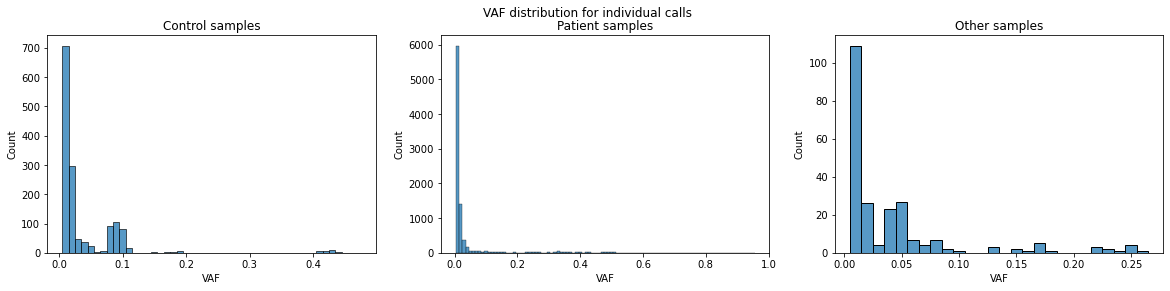

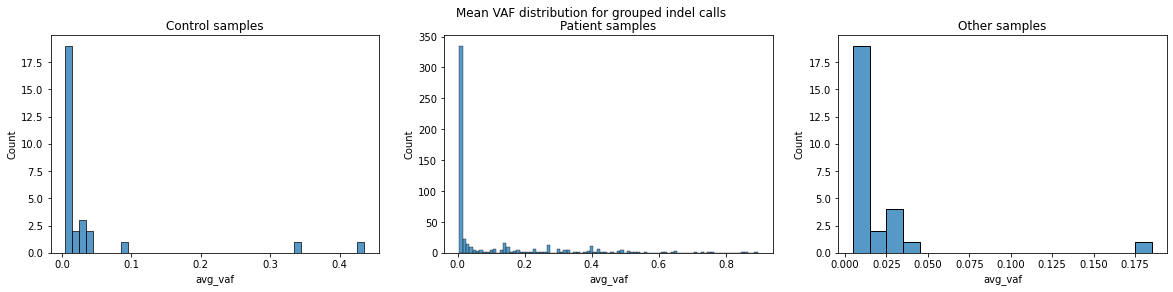

In [10]:
plot_histograms(INDELS_DF, 'VAF', 'VAF distribution for individual calls', binwidth=0.01)
plot_histograms(INDELS_GROUPED_DF, 'avg_vaf', 'Mean VAF distribution for grouped indel calls', binwidth=0.01)

We now look at calls with a VAF below 1% and in (1%, 5%].

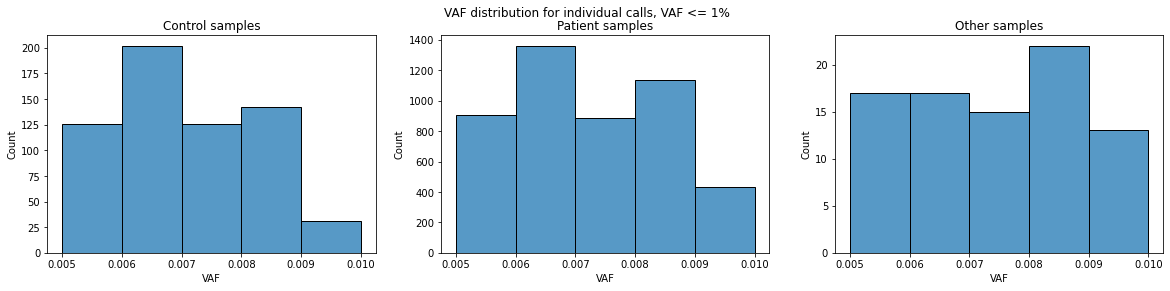

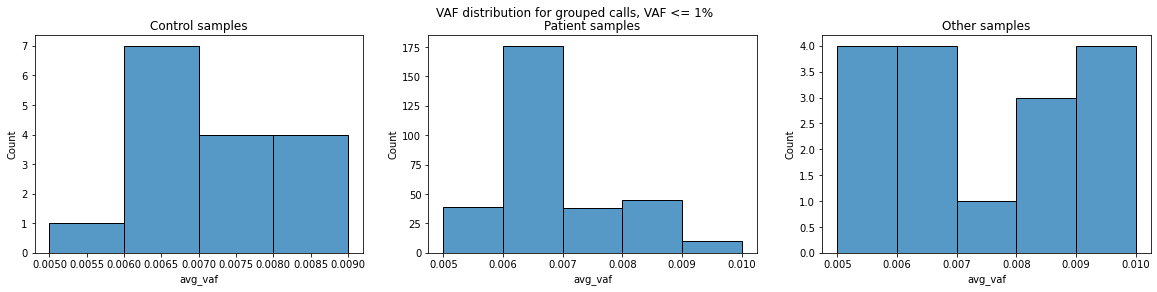

In [11]:
plot_histograms(INDELS_DF_VAF1, 'VAF', 'VAF distribution for individual calls, VAF <= 1%', binwidth=0.001)
plot_histograms(INDELS_GROUPED_DF_VAF1, 'avg_vaf', 'VAF distribution for grouped calls, VAF <= 1%', binwidth=0.001)

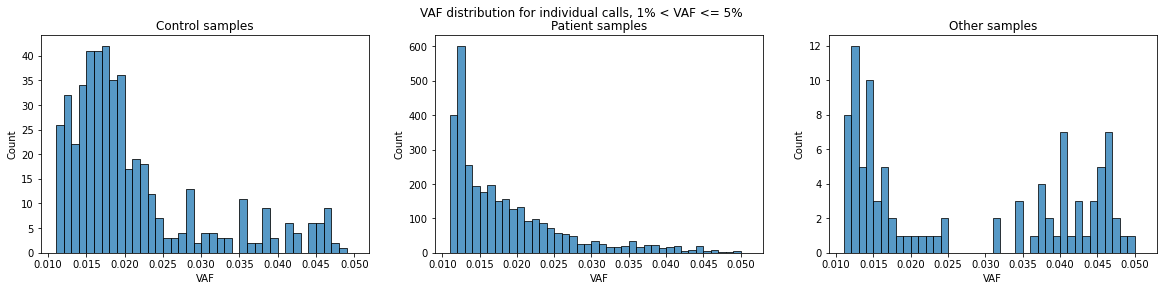

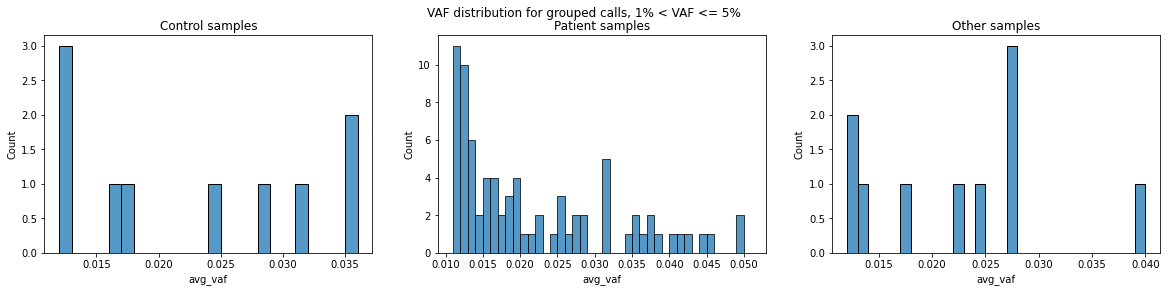

In [12]:
plot_histograms(INDELS_DF_VAF1_5, 'VAF', 'VAF distribution for individual calls, 1% < VAF <= 5%', binwidth=0.001)
plot_histograms(INDELS_GROUPED_DF_VAF1_5, 'avg_vaf', 'VAF distribution for grouped calls, 1% < VAF <= 5%', binwidth=0.001)

### Correlation between VAF and number of occurrences

We plot the VAF against the number of samples containing a variant

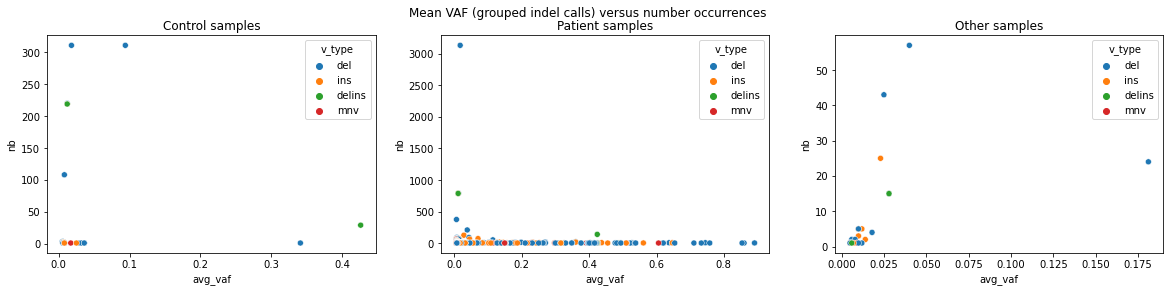

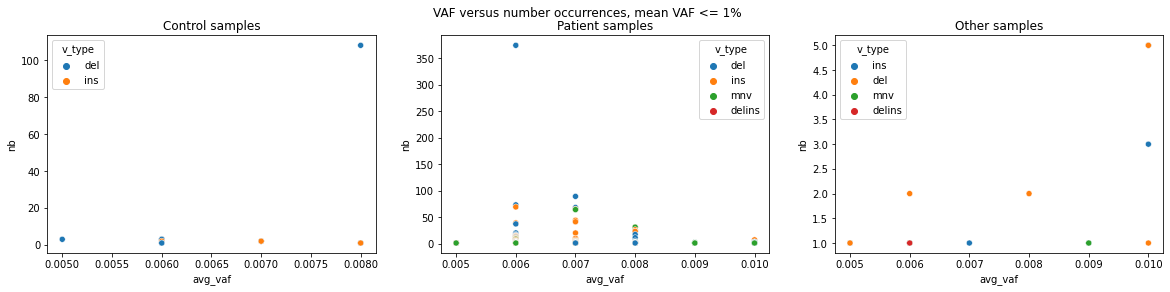

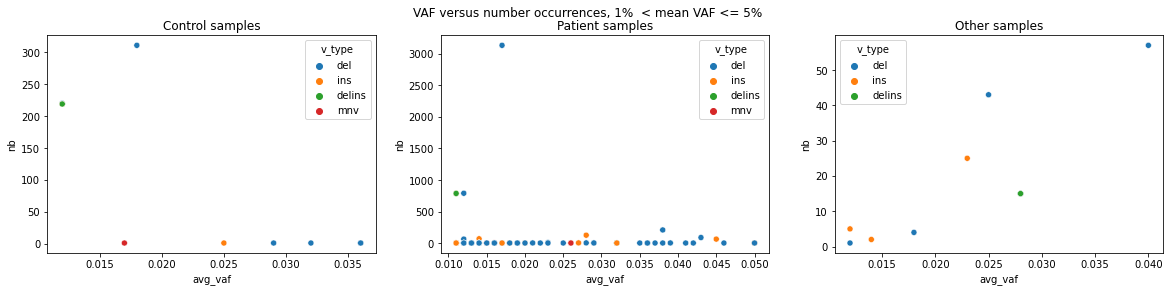

In [13]:
plot_scatter(INDELS_GROUPED_DF, 'avg_vaf', 'nb', 'Mean VAF (grouped indel calls) versus number occurrences')
plot_scatter(INDELS_GROUPED_DF_VAF1, 'avg_vaf', 'nb', 'VAF versus number occurrences, mean VAF <= 1%')
plot_scatter(INDELS_GROUPED_DF_VAF1_5, 'avg_vaf', 'nb', 'VAF versus number occurrences, 1%  < mean VAF <= 5%')

### Groups of co-localized calls

We group together indel calls that are separated by at most 5 bases.

In [14]:
INDELS_GROUPED_COLOCALIZED_DF = {}
for sample_type in SAMPLE_TYPES:
    INDELS_GROUPED_COLOCALIZED_DF[sample_type] = extract_groups_colocalized_calls(INDELS_GROUPED_DF[sample_type])

In [15]:
for sample_type in SAMPLE_TYPES:
    print(f"\n\n# SAMPLE TYPE: {SAMPLE_TYPES_DICT[sample_type]} ###################################################################################################\n")
    for group_id, group_df in INDELS_GROUPED_COLOCALIZED_DF[sample_type].items():
        print(f"\n# Indel(s) co-localized group {group_id} ---------------------------------------------------------------------------------------------------\n")
        print(group_df.to_string(columns=['nb', 'chr', 'pos', 'ref', 'alt', 'avg_vaf', 'v_type', 'features_cov', 'features_seq'], justify='left'))



# SAMPLE TYPE: Control samples ###################################################################################################


# Indel(s) co-localized group 1 ---------------------------------------------------------------------------------------------------

    nb chr    pos       ref                                                                          alt  avg_vaf v_type features_cov             features_seq                                                                         
26  1   chr1  156849061  GGCCACACGCAACTGTCTAGTGGGCCAGGGACTGGTGGTCAAGATTGGTGATTTTGGCATGAGCAGGGATATCTA  G   0.006    del    SCOV:1134,TCOV:7,MCOV:7  WRU1:74,WRU2:1,WRU3:0,WRU4:0,VRU1:0,VRU2:0,VRU3:0,VRU4:0,HPL1:1,HPL2:G,HPR1:1,HPR2:C

# Indel(s) co-localized group 2 ---------------------------------------------------------------------------------------------------

   nb  chr     pos      ref alt   avg_vaf v_type  features_cov               features_seq                                             